In [1]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS

from credit_risk_xai.config import FEATURE_CACHE_PATH, FEATURES_FOR_MODEL
from credit_risk_xai.features.engineer import prepare_modeling_data

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred_proba, n_bins=100, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")


    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and filter data
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[
    (df["ser_aktiv"] == 1) & 
    (df["sme_category"].isin(["Small", "Medium"])) & 
    (df["knc_kncfall"] == 1) &
    (df["bransch_borsbransch_konv"] != "40.0")
    ]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 40 | Samples: 306,985
Target distribution:
target_next_year
0    300486
1      6499
Name: count, dtype: Int64
Imbalance: 46.2:1


In [3]:
from credit_risk_xai.modeling.train import run_lightgbm_training

results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="ser_aktiv==1 & SME∈{Small,Medium} & knc_kncfall==1",  # optional note for W&B
    use_wandb=False,
    wandb_project="credit-risk-xai",
    wandb_run_name="lgbm_finalish_prune",
)

[50]	training's binary_logloss: 0.0478647	valid_1's binary_logloss: 0.0538132
[100]	training's binary_logloss: 0.0403767	valid_1's binary_logloss: 0.0511193
[150]	training's binary_logloss: 0.0355356	valid_1's binary_logloss: 0.050347
[200]	training's binary_logloss: 0.0321534	valid_1's binary_logloss: 0.050156
[250]	training's binary_logloss: 0.0293899	valid_1's binary_logloss: 0.0500833
[300]	training's binary_logloss: 0.0271277	valid_1's binary_logloss: 0.0500264


LightGBM Performance:
  AUC: 0.9476
  PR-AUC: 0.6111

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     60821
           1       0.41      0.93      0.57       576

    accuracy                           0.99     61397
   macro avg       0.71      0.96      0.78     61397
weighted avg       0.99      0.99      0.99     61397


Confusion Matrix:
[[60056    41]
 [  765   535]]


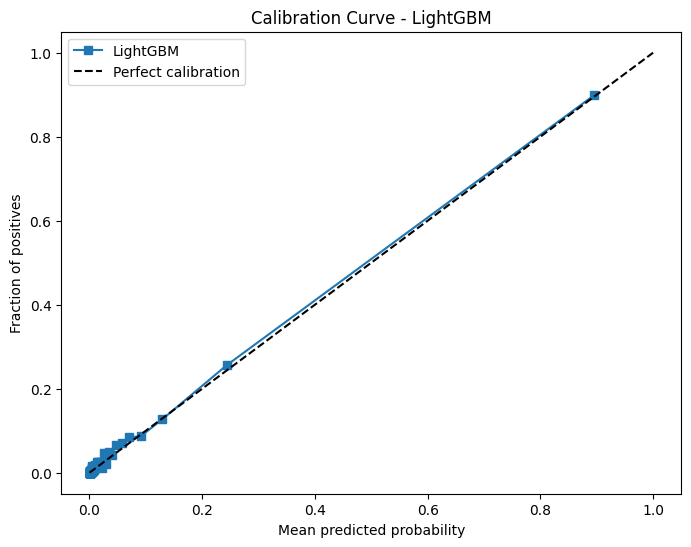

ECE: 0.0029


In [4]:
# Evaluate
model = results["model"]
X_train = results["X_train"]
X_val = results["X_val"]
y_train = results["y_train"]
y_val = results["y_val"]
y_pred_proba = results["y_val_proba"]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"LightGBM Performance:")
print(f"  AUC: {auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_pred, y_val))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

plot_calibration_curve(y_val, y_pred_proba, model_name="LightGBM")

# Phase 1: Foundation & Baseline Comparison

Following the comprehensive XAI thesis plan, we'll establish baselines and infrastructure for all subsequent analyses.

In [5]:
## 1.1 Train Logistic Regression Baseline with Winsorization + Target Encoding

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import winsorize

print("Training Logistic Regression with Winsorization + Target Encoding...")
print(f"Training set: {len(X_train):,} samples | Validation set: {len(X_val):,} samples")
print(f"Training imbalance: {(y_train==0).sum()/(y_train==1).sum():.1f}:1")

# Winsorization function for continuous features
def winsorize_features(X, limits=(0.01, 0.01), categorical_features=None, verbose=True):
    """
    Winsorize continuous features at specified percentiles.
    
    Categorical features are excluded from winsorization.
    Extreme values beyond 1st/99th percentile are capped to those thresholds.
    This prevents coefficient instability in logistic regression while preserving
    the signal that "extreme values indicate higher risk".
    
    Parameters:
    -----------
    X : pd.DataFrame
        Features to winsorize
    limits : tuple
        (lower, upper) proportions to winsorize (default: 1st and 99th percentile)
    categorical_features : list
        List of categorical feature names to exclude from winsorization
    verbose : bool
        Print progress messages
    
    Returns:
    --------
    pd.DataFrame
        Winsorized features
    """
    X_wins = X.copy()
    
    if categorical_features is None:
        categorical_features = []
    
    # Identify categorical columns (category dtype)
    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    categorical_features = list(set(categorical_features + cat_cols))
    
    continuous_cols = [col for col in X.columns if col not in categorical_features]
    
    if verbose:
        print(f"  Winsorizing {len(continuous_cols)} continuous features at {limits[0]*100:.0f}th/{(1-limits[1])*100:.0f}th percentiles")
        print(f"  Excluding {len(categorical_features)} categorical features: {categorical_features}")
    
    for col in continuous_cols:
        # Winsorize only non-NaN values
        mask = X_wins[col].notna()
        if mask.sum() > 0:
            # Convert to numpy array to handle pandas nullable dtypes (Int16, etc.)
            values = X_wins.loc[mask, col].values.astype(float)
            winsorized_values = winsorize(values, limits=limits)
            X_wins.loc[mask, col] = winsorized_values
    
    return X_wins

def target_encode_categorical(X_train, X_val, y_train, categorical_cols, smoothing=10.0):
    """
    Target encoding for categorical variables using median (smoothed mean) of target.
    
    This is a form of "fixed effects" encoding where each category gets replaced
    by its empirical default rate, smoothed toward the global mean to handle
    rare categories.
    
    Formula: encoded_value = (n_cat * mean_cat + smoothing * global_mean) / (n_cat + smoothing)
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    X_val : pd.DataFrame
        Validation features  
    y_train : pd.Series
        Training target
    categorical_cols : list
        Categorical column names
    smoothing : float
        Smoothing factor (higher = more regularization toward global mean)
    
    Returns:
    --------
    tuple : (X_train_encoded, X_val_encoded, encoding_maps)
    """
    X_train_enc = X_train.copy()
    X_val_enc = X_val.copy()
    
    global_mean = y_train.mean()
    encoding_maps = {}
    
    print(f"\n  Target encoding {len(categorical_cols)} categorical features:")
    print(f"  Global default rate: {global_mean:.4f}")
    print(f"  Smoothing parameter: {smoothing}")
    
    for col in categorical_cols:
        if col not in X_train.columns:
            continue
            
        # Compute smoothed mean for each category
        category_stats = pd.DataFrame({
            'count': X_train.groupby(col, observed=True).size(),
            'sum': y_train.groupby(X_train[col], observed=True).sum()
        })
        
        category_stats['smoothed_mean'] = (
            (category_stats['sum'] + smoothing * global_mean) / 
            (category_stats['count'] + smoothing)
        )
        
        encoding_map = category_stats['smoothed_mean'].to_dict()
        encoding_maps[col] = encoding_map
        
        # Apply encoding
        X_train_enc[col] = X_train[col].map(encoding_map).fillna(global_mean)
        X_val_enc[col] = X_val[col].map(encoding_map).fillna(global_mean)
        
        n_categories = len(encoding_map)
        min_enc = category_stats['smoothed_mean'].min()
        max_enc = category_stats['smoothed_mean'].max()
        
        print(f"    {col}: {n_categories} categories → range [{min_enc:.4f}, {max_enc:.4f}]")
    
    return X_train_enc, X_val_enc, encoding_maps

# Step 1: Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist()

# Step 2: Target encode categoricals BEFORE winsorization
# (Target encoding creates continuous values from categories)
X_train_enc, X_val_enc, encoding_maps = target_encode_categorical(
    X_train, X_val, y_train, 
    categorical_cols=categorical_cols,
    smoothing=10.0  # Regularization: higher = more conservative
)

# Step 3: Apply winsorization to all features (now all continuous)
X_train_wins = winsorize_features(X_train_enc, limits=(0.01, 0.01), verbose=True)
X_val_wins = winsorize_features(X_val_enc, limits=(0.01, 0.01), verbose=False)

# Step 4: Create preprocessing pipeline (median imputation + scaling)
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit preprocessor on winsorized training data
X_train_processed = preprocessor.fit_transform(X_train_wins)
X_val_processed = preprocessor.transform(X_val_wins)

print(f"\nPreprocessing complete:")
print(f"  1. Target encoding: Categorical → smoothed default rates")
print(f"  2. Winsorization: Capped extreme values at 1st/99th percentile")
print(f"  3. Imputation: Median imputation for missing values")
print(f"  4. Scaling: StandardScaler (mean=0, std=1)")

# Train logistic regression with L2 regularization
logit_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight=None,
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

print(f"\nTraining Logistic Regression (C=1.0, L2 penalty)...")
logit_model.fit(X_train_processed, y_train)

# Predictions
logit_train_proba = logit_model.predict_proba(X_train_processed)[:, 1]
logit_val_proba = logit_model.predict_proba(X_val_processed)[:, 1]
logit_val_pred = (logit_val_proba >= 0.5).astype(int)

print("✓ Logistic Regression trained with target-encoded categoricals + winsorization")

Training Logistic Regression with Winsorization + Target Encoding...
Training set: 245,588 samples | Validation set: 61,397 samples
Training imbalance: 46.2:1

  Target encoding 1 categorical features:
  Global default rate: 0.0212
  Smoothing parameter: 10.0
    sni_group_3digit: 253 categories → range [0.0004, 0.2459]
  Winsorizing 40 continuous features at 1th/99th percentiles
  Excluding 0 categorical features: []

Preprocessing complete:
  1. Target encoding: Categorical → smoothed default rates
  2. Winsorization: Capped extreme values at 1st/99th percentile
  3. Imputation: Median imputation for missing values
  4. Scaling: StandardScaler (mean=0, std=1)

Training Logistic Regression (C=1.0, L2 penalty)...
✓ Logistic Regression trained with target-encoded categoricals + winsorization


In [6]:
## 1.2 Model Performance Comparison

from sklearn.metrics import brier_score_loss

def compute_ece(y_true, y_pred_proba, n_bins=100):
    """Compute Expected Calibration Error"""
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    return ece

# Evaluate both models
print("=" * 80)
print("TABLE 1: MODEL PERFORMANCE COMPARISON")
print("=" * 80)

metrics = {
    'Model': ['LightGBM', 'Logistic Regression', 'Δ (LightGBM - Logit)'],
    'AUC': [],
    'PR-AUC': [],
    'Brier Score': [],
    'ECE': []
}

# LightGBM metrics
lgbm_auc = roc_auc_score(y_val, y_pred_proba)
lgbm_pr_auc = average_precision_score(y_val, y_pred_proba)
lgbm_brier = brier_score_loss(y_val, y_pred_proba)
lgbm_ece = compute_ece(y_val, y_pred_proba)

metrics['AUC'].append(lgbm_auc)
metrics['PR-AUC'].append(lgbm_pr_auc)
metrics['Brier Score'].append(lgbm_brier)
metrics['ECE'].append(lgbm_ece)

# Logistic Regression metrics
logit_auc = roc_auc_score(y_val, logit_val_proba)
logit_pr_auc = average_precision_score(y_val, logit_val_proba)
logit_brier = brier_score_loss(y_val, logit_val_proba)
logit_ece = compute_ece(y_val, logit_val_proba)

metrics['AUC'].append(logit_auc)
metrics['PR-AUC'].append(logit_pr_auc)
metrics['Brier Score'].append(logit_brier)
metrics['ECE'].append(logit_ece)

# Differences
metrics['AUC'].append(lgbm_auc - logit_auc)
metrics['PR-AUC'].append(lgbm_pr_auc - logit_pr_auc)
metrics['Brier Score'].append(lgbm_brier - logit_brier)
metrics['ECE'].append(lgbm_ece - logit_ece)

performance_df = pd.DataFrame(metrics)
print(performance_df.to_string(index=False))
print("=" * 80)
print("\nNotes:")
print("  - AUC, PR-AUC: Higher is better")
print("  - Brier Score, ECE: Lower is better (better calibration)")
print(f"  - LightGBM improves AUC by {(lgbm_auc - logit_auc)*100:.2f} percentage points")
print(f"  - LightGBM improves PR-AUC by {(lgbm_pr_auc - logit_pr_auc)*100:.2f} percentage points")

TABLE 1: MODEL PERFORMANCE COMPARISON
               Model      AUC   PR-AUC  Brier Score       ECE
            LightGBM 0.947555 0.611126     0.011615  0.002928
 Logistic Regression 0.868454 0.163205     0.019086  0.004950
Δ (LightGBM - Logit) 0.079100 0.447921    -0.007471 -0.002022

Notes:
  - AUC, PR-AUC: Higher is better
  - Brier Score, ECE: Lower is better (better calibration)
  - LightGBM improves AUC by 7.91 percentage points
  - LightGBM improves PR-AUC by 44.79 percentage points


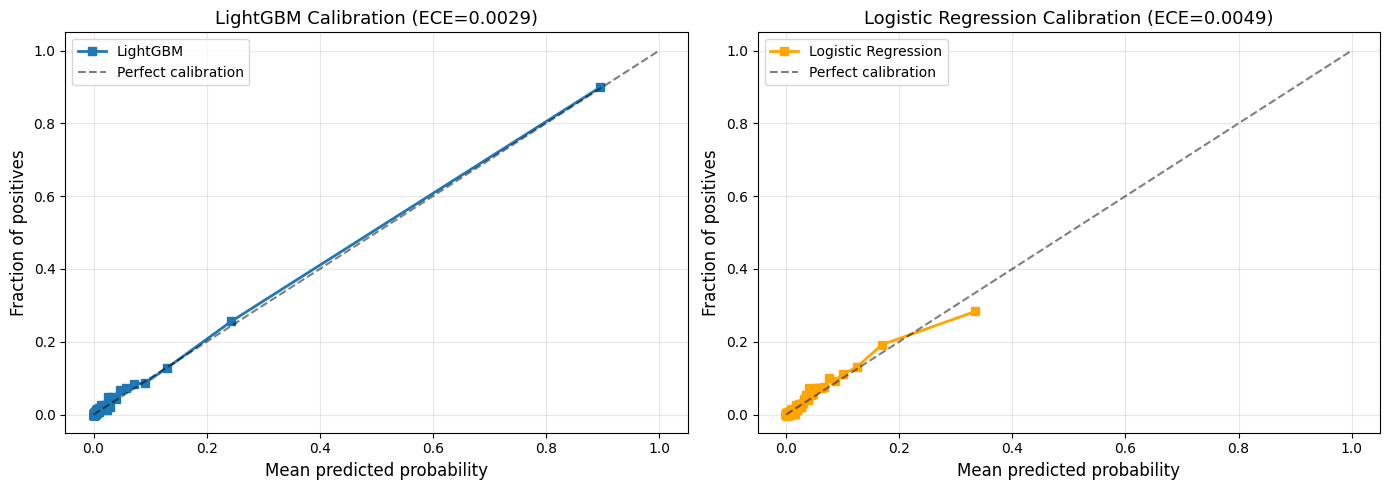


Calibration Analysis:
  LightGBM ECE: 0.0029 - Well calibrated
  Logistic ECE: 0.0049 - Well calibrated


In [7]:
## Calibration Curves Comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LightGBM calibration
from sklearn.calibration import calibration_curve
fraction_pos_lgbm, mean_pred_lgbm = calibration_curve(
    y_val, y_pred_proba, n_bins=100, strategy='quantile'
)
axes[0].plot(mean_pred_lgbm, fraction_pos_lgbm, 's-', label='LightGBM', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)
axes[0].set_xlabel('Mean predicted probability', fontsize=12)
axes[0].set_ylabel('Fraction of positives', fontsize=12)
axes[0].set_title(f'LightGBM Calibration (ECE={lgbm_ece:.4f})', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Logistic Regression calibration
fraction_pos_logit, mean_pred_logit = calibration_curve(
    y_val, logit_val_proba, n_bins=100, strategy='quantile'
)
axes[1].plot(mean_pred_logit, fraction_pos_logit, 's-', label='Logistic Regression', 
             linewidth=2, color='orange')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)
axes[1].set_xlabel('Mean predicted probability', fontsize=12)
axes[1].set_ylabel('Fraction of positives', fontsize=12)
axes[1].set_title(f'Logistic Regression Calibration (ECE={logit_ece:.4f})', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCalibration Analysis:")
print(f"  LightGBM ECE: {lgbm_ece:.4f} - {'Well calibrated' if lgbm_ece < 0.05 else 'Needs calibration'}")
print(f"  Logistic ECE: {logit_ece:.4f} - {'Well calibrated' if logit_ece < 0.05 else 'Needs calibration'}")

In [8]:
## 1.3 Compute SHAP Values for Both Models

print("=" * 80)
print("Computing SHAP values...")
print("=" * 80)

# LightGBM SHAP values
print("\n[1/2] Computing SHAP for LightGBM...")
print(f"  Sample size: {len(X_val):,} observations")

start_time = time.time()
explainer_lgbm = shap.TreeExplainer(model)
shap_values_lgbm = explainer_lgbm.shap_values(X_val)

# TreeExplainer returns [neg_class, pos_class] for binary classification
# We want SHAP values for the positive class (default/credit event)
if isinstance(shap_values_lgbm, list):
    shap_values_lgbm = shap_values_lgbm[1]  # Positive class

elapsed = time.time() - start_time
print(f"  ✓ LightGBM SHAP computed in {elapsed:.1f}s")
print(f"  Shape: {shap_values_lgbm.shape}")

# Logistic Regression SHAP values
print("\n[2/2] Computing SHAP for Logistic Regression...")
start_time = time.time()

# For linear models, use LinearExplainer (much faster than KernelExplainer)
# LinearExplainer requires preprocessed data
explainer_logit = shap.LinearExplainer(
    logit_model, 
    X_train_processed,  # Background data (preprocessed)
    feature_perturbation="interventional"
)
shap_values_logit = explainer_logit.shap_values(X_val_processed)

elapsed = time.time() - start_time
print(f"  ✓ Logistic SHAP computed in {elapsed:.1f}s")
print(f"  Shape: {shap_values_logit.shape}")

print("\n" + "=" * 80)
print("SHAP computation complete!")
print("=" * 80)

Computing SHAP values...

[1/2] Computing SHAP for LightGBM...
  Sample size: 61,397 observations
  ✓ LightGBM SHAP computed in 7.1s
  Shape: (61397, 40)

[2/2] Computing SHAP for Logistic Regression...
  ✓ Logistic SHAP computed in 0.0s
  Shape: (61397, 40)

SHAP computation complete!


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [9]:
## Cache SHAP values for reuse

import pickle
from pathlib import Path

# Create results directory if it doesn't exist
results_dir = PROJ_ROOT / "results" / "xai_exploration"
results_dir.mkdir(parents=True, exist_ok=True)

# Save SHAP values and related objects
cache_file = results_dir / "shap_cache.pkl"

shap_cache = {
    'shap_values_lgbm': shap_values_lgbm,
    'shap_values_logit': shap_values_logit,
    'explainer_lgbm': explainer_lgbm,
    'explainer_logit': explainer_logit,
    'X_val': X_val,
    'X_val_processed': X_val_processed,
    'y_val': y_val,
    'y_pred_proba_lgbm': y_pred_proba,
    'y_pred_proba_logit': logit_val_proba,
    'feature_names': X_val.columns.tolist()
}

print(f"Caching SHAP values to: {cache_file}")
with open(cache_file, 'wb') as f:
    pickle.dump(shap_cache, f)

print(f"✓ SHAP cache saved ({cache_file.stat().st_size / 1024 / 1024:.1f} MB)")
print(f"\nCached objects:")
for key, val in shap_cache.items():
    if hasattr(val, 'shape'):
        print(f"  - {key}: {val.shape}")
    elif isinstance(val, list):
        print(f"  - {key}: {len(val)} items")
    else:
        print(f"  - {key}: {type(val).__name__}")

Caching SHAP values to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_exploration/shap_cache.pkl
✓ SHAP cache saved (70.4 MB)

Cached objects:
  - shap_values_lgbm: (61397, 40)
  - shap_values_logit: (61397, 40)
  - explainer_lgbm: TreeExplainer
  - explainer_logit: LinearExplainer
  - X_val: (61397, 40)
  - X_val_processed: (61397, 40)
  - y_val: (61397,)
  - y_pred_proba_lgbm: (61397,)
  - y_pred_proba_logit: (61397,)
  - feature_names: 40 items


# Phase 2: Global Model Understanding (Chapter 1)

In this section, we analyze what the models learned and how they differ from traditional credit theory.

In [10]:
## 2.1 Feature Importance Hierarchy

print("=" * 80)
print("TABLE 2: FEATURE IMPORTANCE COMPARISON (Top 20 Features)")
print("=" * 80)

# SHAP importance for both models (mean absolute SHAP)
feature_names = X_val.columns.tolist()

lgbm_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'lgbm_shap': np.abs(shap_values_lgbm).mean(axis=0)
})

logit_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'logit_shap': np.abs(shap_values_logit).mean(axis=0)
})

# LightGBM gain importance
# Note: Use feature_name_ (attribute) or booster_.feature_name() depending on sklearn wrapper
lgbm_importance_gain = pd.DataFrame({
    'feature': feature_names,  # Use the same feature names from X_val
    'lgbm_gain': model.feature_importances_  # This is the sklearn-compatible way
})

# Logistic regression: use absolute value of standardized coefficients
# Standardized coefficients represent importance when features are on same scale
logit_coefficients = pd.DataFrame({
    'feature': feature_names,
    'logit_coef': np.abs(logit_model.coef_[0])
})

# Merge all importance measures
importance_comparison = (
    lgbm_importance_shap
    .merge(logit_importance_shap, on='feature')
    .merge(lgbm_importance_gain, on='feature')
    .merge(logit_coefficients, on='feature')
)

# Normalize to 0-100 scale for comparison
for col in ['lgbm_shap', 'logit_shap', 'lgbm_gain', 'logit_coef']:
    importance_comparison[f'{col}_norm'] = (
        100 * importance_comparison[col] / importance_comparison[col].max()
    )

# Add rankings
importance_comparison['lgbm_shap_rank'] = importance_comparison['lgbm_shap'].rank(ascending=False)
importance_comparison['logit_shap_rank'] = importance_comparison['logit_shap'].rank(ascending=False)

# Sort by LightGBM SHAP importance
importance_comparison = importance_comparison.sort_values('lgbm_shap', ascending=False)

# Display top 20
top_20 = importance_comparison.head(20)[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 
     'lgbm_shap_norm', 'logit_shap_norm', 'lgbm_gain_norm', 'logit_coef_norm']
].copy()

top_20['rank_diff'] = top_20['logit_shap_rank'] - top_20['lgbm_shap_rank']

print(top_20.to_string(index=False))
print("=" * 80)
print("\nNotes:")
print("  - *_norm: Normalized importance (0-100 scale)")
print("  - rank_diff: Positive = more important in Logit vs LightGBM")
print("  - SHAP values measure actual predictive contribution")
print("  - Gain measures average information gain from splits (LightGBM only)")

TABLE 2: FEATURE IMPORTANCE COMPARISON (Top 20 Features)
                     feature  lgbm_shap_rank  logit_shap_rank  lgbm_shap_norm  logit_shap_norm  lgbm_gain_norm  logit_coef_norm  rank_diff
              dividend_yield             1.0              1.0      100.000000       100.000000        8.039492       100.000000        0.0
            sni_group_3digit             2.0              3.0       57.703599        59.128162      100.000000        52.242892        1.0
        ratio_cash_liquidity             3.0              2.0       42.750948        72.899713        9.873061        82.507424       -1.0
          rr01_ntoms_yoy_abs             4.0             17.0       39.347571        16.030474       16.572638        21.878797       13.0
                 ny_skuldgrd             5.0             24.0       35.637361         8.877397        9.097320        10.952508       19.0
                 ny_avkegkap             6.0             35.0       34.575455         3.232765       13.89280

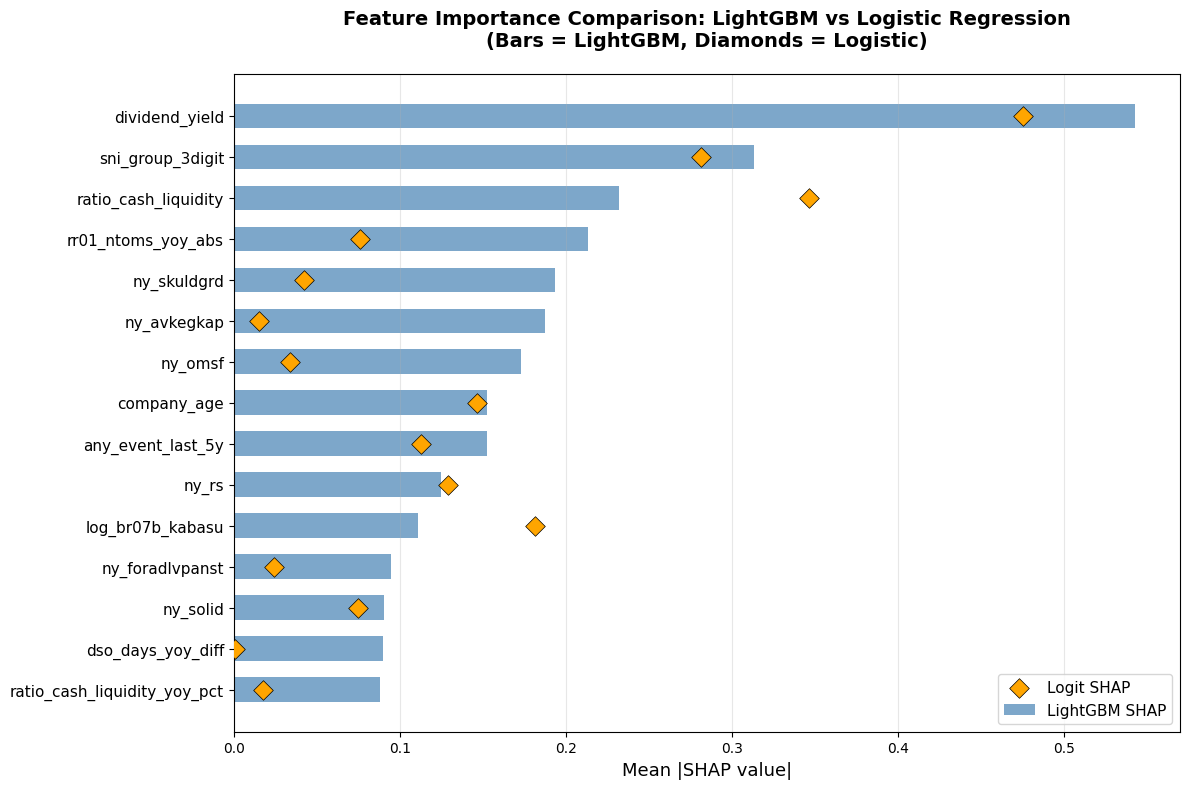


KEY INSIGHTS:
--------------------------------------------------------------------------------

✓ Features LightGBM prioritizes over Logit:
   • rr01_ntoms_yoy_abs: LightGBM rank 4, Logit rank 17
   • ny_skuldgrd: LightGBM rank 5, Logit rank 24
   • ny_avkegkap: LightGBM rank 6, Logit rank 35
   • ny_omsf: LightGBM rank 7, Logit rank 27

✓ Features Logit prioritizes over LightGBM:
   • ratio_depreciation_cost: Logit rank 8, LightGBM rank 22
   • revenue_drawdown_5y: Logit rank 9, LightGBM rank 23
   • ny_nettomarg: Logit rank 4, LightGBM rank 27
   • log_rr15_resar: Logit rank 6, LightGBM rank 30
   • ny_kasslikv: Logit rank 5, LightGBM rank 36

✓ Biggest discrepancies:

Features MORE important in Logit:
   • ny_avkegkap: Logit values it 29 ranks higher
   • dso_days_yoy_diff: Logit values it 26 ranks higher
   • ny_omsf: Logit values it 20 ranks higher
   • ny_skuldgrd: Logit values it 19 ranks higher
   • dpo_days_yoy_diff: Logit values it 18 ranks higher

Features MORE important in

In [11]:
## Feature Importance Comparison Visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Get top 15 features by LightGBM SHAP
top_15_lgbm = importance_comparison.head(15).copy()

# Sort by lgbm_shap for plotting (ascending for horizontal bar chart)
top_15_lgbm = top_15_lgbm.sort_values('lgbm_shap')

y_pos = np.arange(len(top_15_lgbm))

# Plot LightGBM SHAP as bars
ax.barh(y_pos, top_15_lgbm['lgbm_shap'], 
        color='steelblue', alpha=0.7, label='LightGBM SHAP', height=0.6)

# Overlay Logit SHAP as markers
ax.scatter(top_15_lgbm['logit_shap'], y_pos, 
           color='orange', s=100, marker='D', 
           label='Logit SHAP', zorder=3, edgecolors='black', linewidths=0.5)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(top_15_lgbm['feature'], fontsize=11)
ax.set_xlabel('Mean |SHAP value|', fontsize=13)
ax.set_title('Feature Importance Comparison: LightGBM vs Logistic Regression\n' + 
             '(Bars = LightGBM, Diamonds = Logistic)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

# Add vertical line at x=0 for reference
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHTS:")
print("-" * 80)

# Add rank_diff column for analysis
importance_comparison['rank_diff'] = (
    importance_comparison['logit_shap_rank'] - importance_comparison['lgbm_shap_rank']
)

# Features where LightGBM ranks much higher than Logit
lgbm_prioritized = importance_comparison[
    (importance_comparison['lgbm_shap_rank'] <= 10) & 
    (importance_comparison['rank_diff'] > 5)
]

if len(lgbm_prioritized) > 0:
    print(f"\n✓ Features LightGBM prioritizes over Logit:")
    for _, row in lgbm_prioritized.iterrows():
        print(f"   • {row['feature']}: LightGBM rank {int(row['lgbm_shap_rank'])}, "
              f"Logit rank {int(row['logit_shap_rank'])}")

# Features where Logit ranks much higher than LightGBM
logit_prioritized = importance_comparison[
    (importance_comparison['logit_shap_rank'] <= 10) & 
    (importance_comparison['rank_diff'] < -5)
]

if len(logit_prioritized) > 0:
    print(f"\n✓ Features Logit prioritizes over LightGBM:")
    for _, row in logit_prioritized.iterrows():
        print(f"   • {row['feature']}: Logit rank {int(row['logit_shap_rank'])}, "
              f"LightGBM rank {int(row['lgbm_shap_rank'])}")

# Summary of differences
print(f"\n✓ Biggest discrepancies:")
top_discrepancies = importance_comparison.nlargest(5, 'rank_diff')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'rank_diff']
]
print("\nFeatures MORE important in Logit:")
for _, row in top_discrepancies.iterrows():
    if row['rank_diff'] > 0:
        print(f"   • {row['feature']}: Logit values it {int(row['rank_diff'])} ranks higher")

bottom_discrepancies = importance_comparison.nsmallest(5, 'rank_diff')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'rank_diff']
]
print("\nFeatures MORE important in LightGBM:")
for _, row in bottom_discrepancies.iterrows():
    if row['rank_diff'] < 0:
        print(f"   • {row['feature']}: LightGBM values it {int(abs(row['rank_diff']))} ranks higher")

In [12]:
## 2.2 ALE (Accumulated Local Effects) Plots with Model Comparison

# Custom ALE implementation
def compute_ale_1d(model, X, feature, grid_size=50, predict_fn=None, percentile_range=(5, 95)):
    """
    Compute 1D ALE plot for a given feature.
    
    Parameters:
    -----------
    model : trained model with predict_proba method
    X : pd.DataFrame, input features
    feature : str, feature name to compute ALE for
    grid_size : int, number of grid points (ignored for binary)
    predict_fn : callable, custom prediction function (default: model.predict_proba)
    percentile_range : tuple, (lower, upper) percentiles to focus ALE on (default: 5th-95th)
    
    Returns:
    --------
    tuple : (grid_centers, ale_cumsum, counts, percentile_bounds)
    """
    if predict_fn is None:
        predict_fn = lambda x: model.predict_proba(x)[:, 1]
    
    X_work = X.copy()
    feat_values = X_work[feature].dropna().values
    
    # Check if binary/low cardinality
    unique_vals = np.unique(feat_values)
    is_binary = len(unique_vals) <= 3
    
    if is_binary:
        # Binary/categorical feature: compute ALE for each unique value
        print(f"    Binary/categorical feature with {len(unique_vals)} unique values")
        
        # Sort unique values
        unique_vals = np.sort(unique_vals)
        grid = unique_vals
        
        # For binary, we just compute the difference between categories
        ale_values = []
        counts_list = []
        
        for i in range(len(grid)):
            # Count observations at this value
            at_value = (X_work[feature] == grid[i]).sum()
            counts_list.append(at_value)
            
            if i == 0:
                # First value: baseline (set to 0)
                ale_values.append(0)
            else:
                # Compute difference from previous value
                X_sample = X_work.copy()
                
                # Predict at current value
                X_curr = X_sample.copy()
                X_curr[feature] = grid[i]
                pred_curr = predict_fn(X_curr).mean()
                
                # Predict at previous value
                X_prev = X_sample.copy()
                X_prev[feature] = grid[i-1]
                pred_prev = predict_fn(X_prev).mean()
                
                # ALE is cumulative difference
                ale_values.append(pred_curr - pred_prev)
        
        ale_cumsum = np.cumsum(ale_values)
        counts = np.array(counts_list)
        
        # Center at weighted mean
        if counts.sum() > 0:
            weighted_mean = np.average(ale_cumsum, weights=counts)
            ale_cumsum = ale_cumsum - weighted_mean
        
        grid_centers = grid  # For binary, grid centers are just the values
        percentile_bounds = (grid.min(), grid.max())
        
    else:
        # Continuous feature: simple quantile-based grid
        p_lower, p_upper = percentile_range
        lower_bound = np.percentile(feat_values, p_lower)
        upper_bound = np.percentile(feat_values, p_upper)

        # Filter to interpretable range (5th-95th percentile)
        interpretable_values = feat_values[(feat_values >= lower_bound) & (feat_values <= upper_bound)]

        # Create quantile-based grid
        quantiles = np.linspace(0, 1, grid_size + 1)
        grid = np.quantile(interpretable_values, quantiles)
        grid = np.unique(grid)

        # Initialize ALE
        ale_values = np.zeros(len(grid) - 1)
        counts = np.zeros(len(grid) - 1)

        # Compute local effects for each interval
        for i in range(len(grid) - 1):
            in_interval = (X_work[feature] >= grid[i]) & (X_work[feature] < grid[i + 1])

            if in_interval.sum() == 0:
                continue

            X_interval = X_work[in_interval].copy()

            # Predict at lower bound
            X_lower = X_interval.copy()
            X_lower[feature] = grid[i]
            pred_lower = predict_fn(X_lower)

            # Predict at upper bound
            X_upper = X_interval.copy()
            X_upper[feature] = grid[i + 1]
            pred_upper = predict_fn(X_upper)

            # Local effect
            ale_values[i] = (pred_upper - pred_lower).mean()
            counts[i] = in_interval.sum()

        # Accumulate effects
        ale_cumsum = np.cumsum(ale_values)

        # Center ALE (mean = 0)
        valid_counts = counts[counts > 0]
        valid_ale = ale_cumsum[counts > 0]

        if len(valid_counts) > 0:
            ale_cumsum = ale_cumsum - np.average(valid_ale, weights=valid_counts)
        else:
            ale_cumsum = np.zeros_like(ale_cumsum)

        # Grid centers for plotting
        grid_centers = (grid[:-1] + grid[1:]) / 2
        percentile_bounds = (lower_bound, upper_bound)
    
    return grid_centers, ale_cumsum, counts, percentile_bounds

print("✓ ALE computation function defined")
print("  - Handles binary and continuous features")
print("  - Uses simple quantile-based grid (5th-95th percentile)")

✓ ALE computation function defined
  - Handles binary and continuous features
  - Uses simple quantile-based grid (5th-95th percentile)


In [13]:
## Generate ALE plots for Top 15 CONTINUOUS features (5th-95th percentile range)

# Get top continuous features by LightGBM SHAP importance (skip categoricals, get exactly 15)
top_features_all = importance_comparison['feature'].tolist()
top_continuous_features = []
for f in top_features_all:
    if X_val[f].dtype.name != 'category':
        top_continuous_features.append(f)
        if len(top_continuous_features) == 15:
            break

print(f"Selected first 15 continuous features (skipped categoricals):")
for i, f in enumerate(top_continuous_features, 1):
    print(f"  {i}. {f}")

# Prediction functions for both models
def predict_lgbm(X):
    return model.predict_proba(X)[:, 1]

def predict_logit(X):
    """
    Apply full preprocessing pipeline for logit (SILENT mode).
    1. Target encode categoricals
    2. Winsorize continuous features  
    3. Impute + scale
    """
    # Identify categorical columns
    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    
    # Target encode using training encodings
    X_enc = X.copy()
    for col in cat_cols:
        if col in encoding_maps:
            global_mean = y_train.mean()
            X_enc[col] = X[col].map(encoding_maps[col]).fillna(global_mean)
    
    # Winsorize (SILENT - verbose=False)
    X_wins = winsorize_features(X_enc, limits=(0.01, 0.01), verbose=False)
    
    # Preprocess and predict
    X_processed = preprocessor.transform(X_wins)
    return logit_model.predict_proba(X_processed)[:, 1]

# Compute ALE for continuous features only
ale_results = {}

for i, feature in enumerate(top_continuous_features, 1):
    print(f"[{i}/15] Computing ALE for {feature}...")
    
    try:
        # LightGBM ALE (5th-95th percentile)
        grid_lgbm, ale_lgbm, counts, bounds = compute_ale_1d(
            model, X_val, feature, grid_size=40, predict_fn=predict_lgbm,
            percentile_range=(5, 95)
        )
        
        # Logistic Regression ALE (5th-95th percentile)
        grid_logit, ale_logit, _, _ = compute_ale_1d(
            logit_model, X_val, feature, grid_size=40, predict_fn=predict_logit,
            percentile_range=(5, 95)
        )
        
        ale_results[feature] = {
            'grid_lgbm': grid_lgbm,
            'ale_lgbm': ale_lgbm,
            'grid_logit': grid_logit,
            'ale_logit': ale_logit,
            'counts': counts,
            'bounds': bounds,  # (5th percentile, 95th percentile)
            'feature_values': X_val[feature].dropna().values
        }
        
    except Exception as e:
        print(f"   ⚠ Error computing ALE for {feature}: {e}")
        continue

print(f"\n✓ ALE computation complete for {len(ale_results)} continuous features")
print(f"\nNote:")
print(f"  • ALE plots show 5th-95th percentile range (90% of data)")
print(f"  • Extreme values beyond this range excluded for interpretability")
print(f"  • Categorical features (like sni_group_3digit) shown via SHAP dependence plots instead")

Selected first 15 continuous features (skipped categoricals):
  1. dividend_yield
  2. ratio_cash_liquidity
  3. rr01_ntoms_yoy_abs
  4. ny_skuldgrd
  5. ny_avkegkap
  6. ny_omsf
  7. company_age
  8. any_event_last_5y
  9. ny_rs
  10. log_br07b_kabasu
  11. ny_foradlvpanst
  12. ny_solid
  13. dso_days_yoy_diff
  14. ratio_cash_liquidity_yoy_pct
  15. dpo_days_yoy_diff
[1/15] Computing ALE for dividend_yield...
[2/15] Computing ALE for ratio_cash_liquidity...
[3/15] Computing ALE for rr01_ntoms_yoy_abs...
[4/15] Computing ALE for ny_skuldgrd...
[5/15] Computing ALE for ny_avkegkap...
[6/15] Computing ALE for ny_omsf...
[7/15] Computing ALE for company_age...
[8/15] Computing ALE for any_event_last_5y...
    Binary/categorical feature with 2 unique values
    Binary/categorical feature with 2 unique values
[9/15] Computing ALE for ny_rs...
[10/15] Computing ALE for log_br07b_kabasu...
[11/15] Computing ALE for ny_foradlvpanst...
[12/15] Computing ALE for ny_solid...
[13/15] Computing A

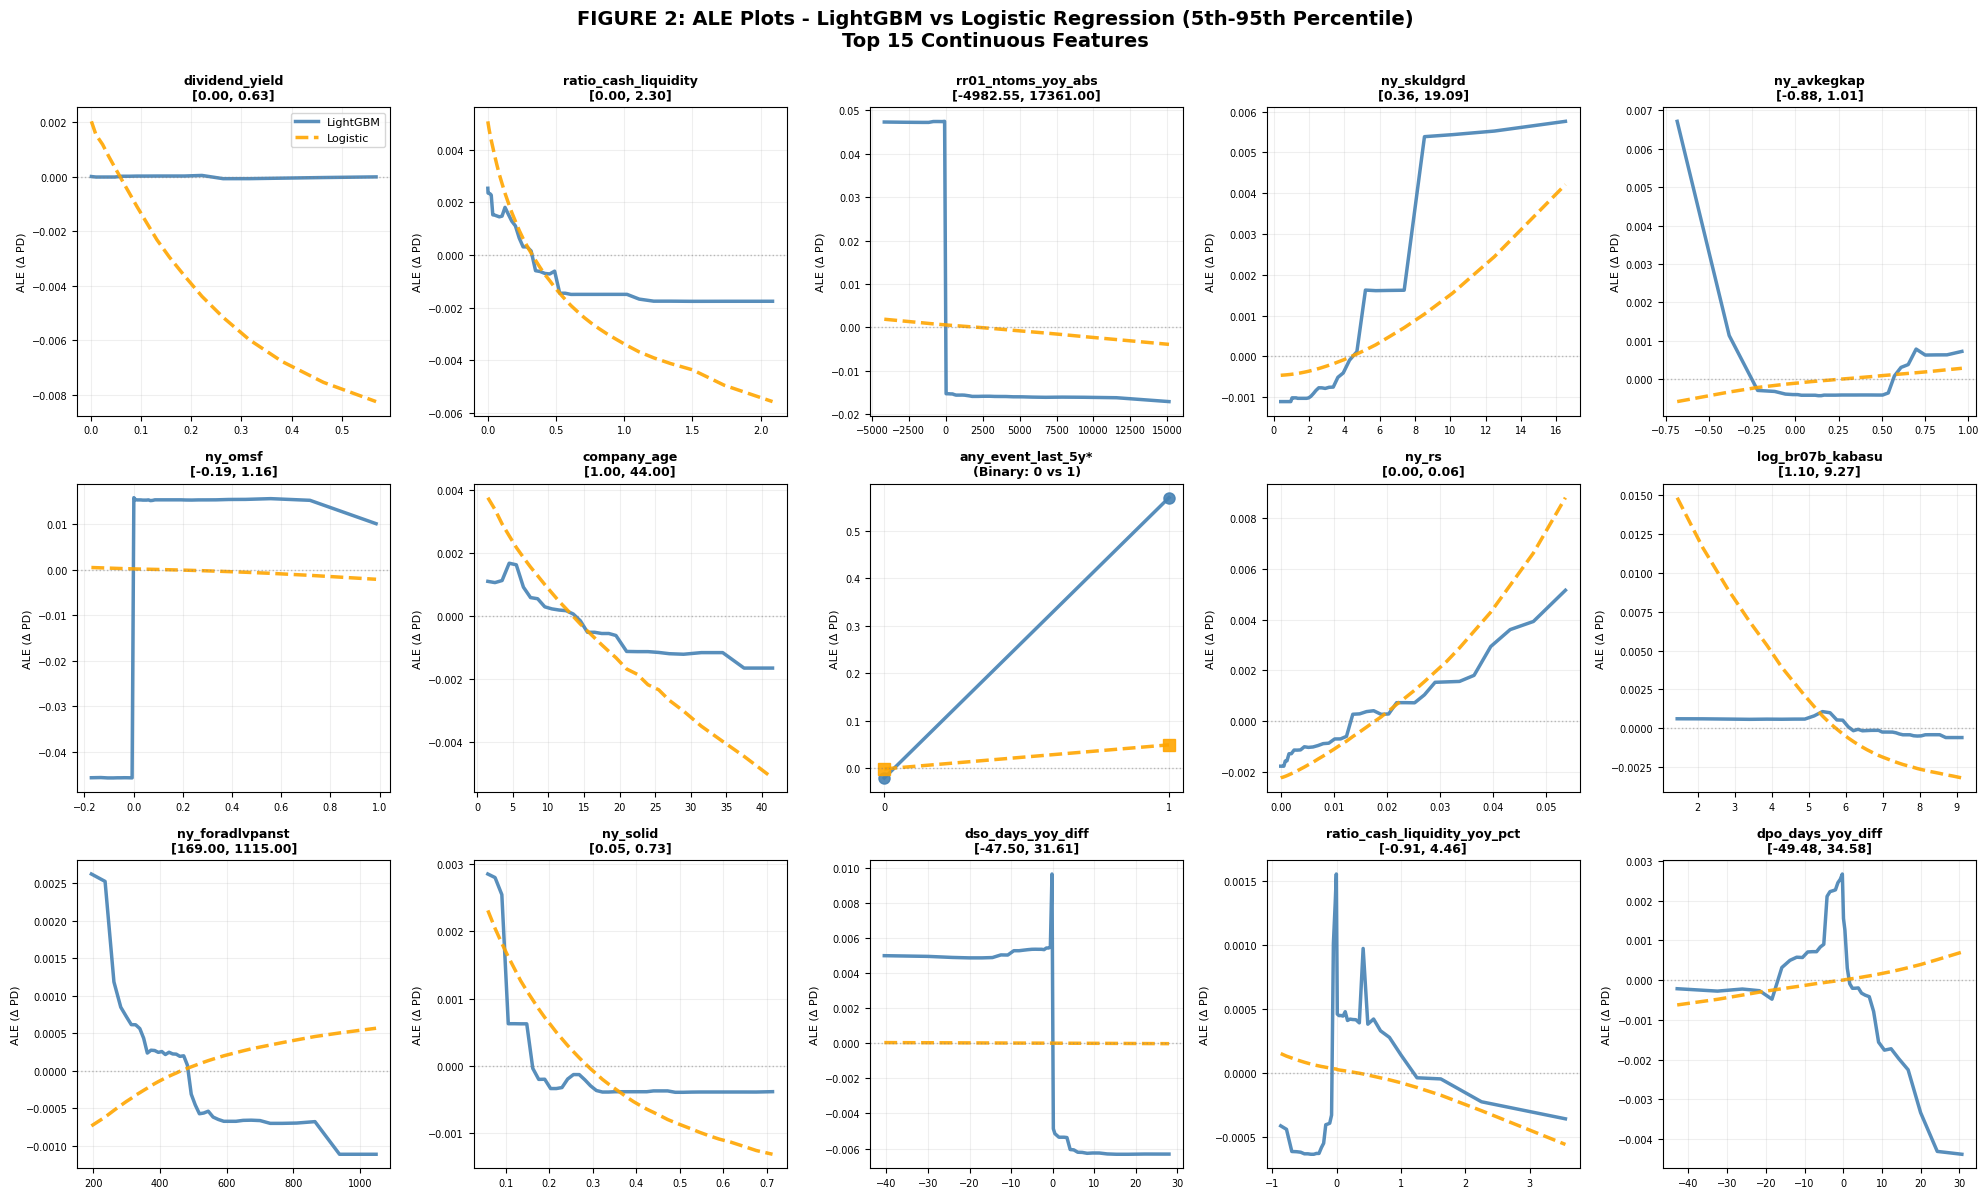

In [14]:
## Visualize ALE Plots

n_plots = len(ale_results)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for idx, (feature, data) in enumerate(ale_results.items()):
    ax = axes[idx]
    
    if len(data['grid_lgbm']) == 0:
        ax.text(0.5, 0.5, f"{feature}\n(no variation)", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(feature, fontsize=9, fontweight='bold')
        continue
    
    is_binary = len(data['grid_lgbm']) <= 3
    
    ax.plot(data['grid_lgbm'], data['ale_lgbm'], 
            label='LightGBM', linewidth=2.5, color='steelblue', alpha=0.9,
            marker='o' if is_binary else None, markersize=8)
    
    ax.plot(data['grid_logit'], data['ale_logit'], 
            label='Logistic', linewidth=2.5, color='orange', alpha=0.9, 
            linestyle='--', marker='s' if is_binary else None, markersize=8)
    
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Fix matplotlib auto-scaling: explicitly set x-limits to show full range
    if not is_binary:
        all_x = np.concatenate([data['grid_lgbm'], data['grid_logit']])
        x_padding = (all_x.max() - all_x.min()) * 0.05
        ax.set_xlim(all_x.min() - x_padding, all_x.max() + x_padding)
    
    lower_bound, upper_bound = data['bounds']
    if is_binary:
        ax.set_title(f"{feature}*\n(Binary: 0 vs 1)", fontsize=9, fontweight='bold')
        ax.set_xticks(data['grid_lgbm'])
        ax.set_xticklabels([f"{int(v)}" for v in data['grid_lgbm']])
    else:
        ax.set_title(f"{feature}\n[{lower_bound:.2f}, {upper_bound:.2f}]", fontsize=9, fontweight='bold')
    
    ax.set_ylabel('ALE (Δ PD)', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.grid(alpha=0.2)
    
    if idx == 0:
        ax.legend(loc='best', fontsize=8)

for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'FIGURE 2: ALE Plots - LightGBM vs Logistic Regression (5th-95th Percentile)\n' + 
             f'Top {n_plots} Continuous Features', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

Creating SHAP summary plots (split into two figures for readability)...


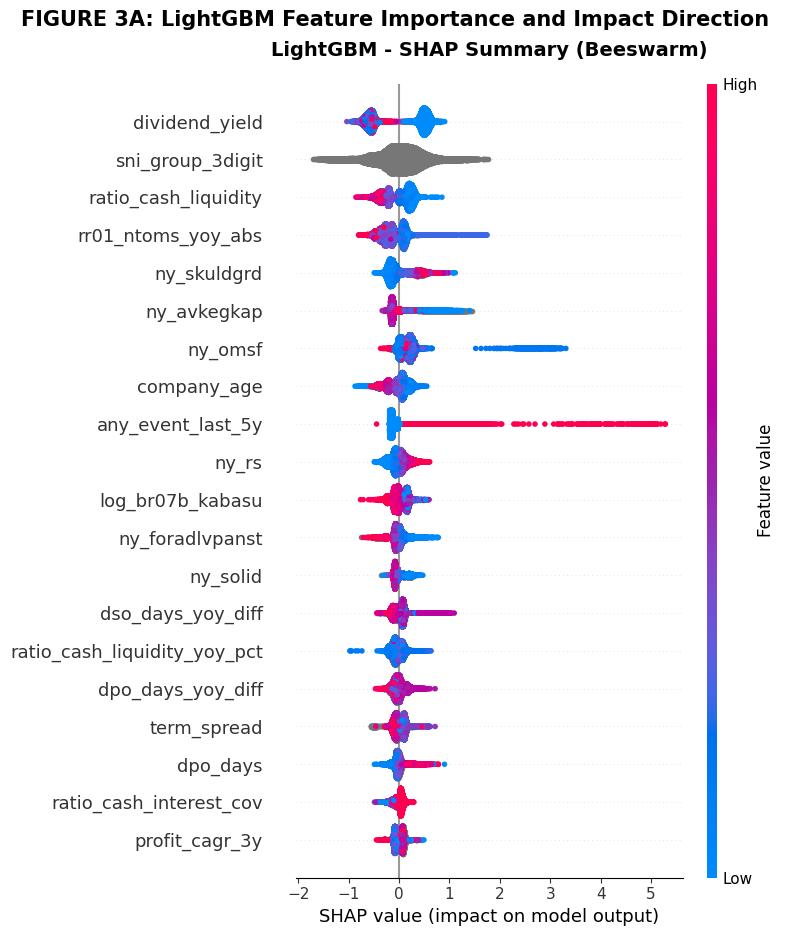

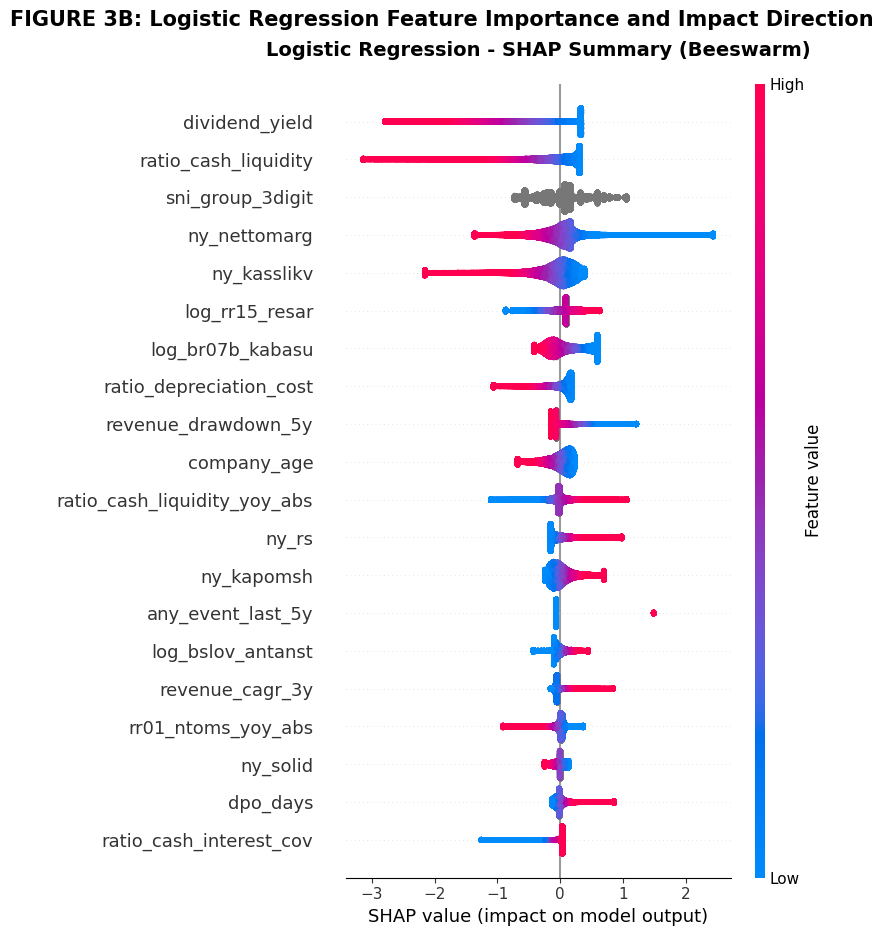


READING THE BEESWARM PLOTS:
  • Y-axis: Features (sorted by importance)
  • X-axis: SHAP value (impact on model output)
  • Color: Feature value (red=high, blue=low)
  • Each dot: One observation
  • Spread: Distribution of impacts across dataset

Key insights:
  - Red dots on right: High feature value → increases risk
  - Blue dots on left: Low feature value → decreases risk
  - Wide spread: Feature has variable impact

Note: Plots are now split into separate figures for better readability and thesis formatting


In [15]:
## 2.3 SHAP Summary Visualizations

# Split into two separate figures for better readability
print("Creating SHAP summary plots (split into two figures for readability)...")

# FIGURE 3A: LightGBM SHAP Summary
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
shap.summary_plot(
    shap_values_lgbm,
    X_val,
    max_display=20,
    show=False
)
plt.title('LightGBM - SHAP Summary (Beeswarm)', fontsize=14, fontweight='bold', pad=20)
plt.suptitle('FIGURE 3A: LightGBM Feature Importance and Impact Direction',
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# FIGURE 3B: Logistic Regression SHAP Summary
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
shap.summary_plot(
    shap_values_logit,
    X_val,  # Use original feature names
    max_display=20,
    show=False
)
plt.title('Logistic Regression - SHAP Summary (Beeswarm)', fontsize=14, fontweight='bold', pad=20)
plt.suptitle('FIGURE 3B: Logistic Regression Feature Importance and Impact Direction',
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\nREADING THE BEESWARM PLOTS:")
print("=" * 80)
print("  • Y-axis: Features (sorted by importance)")
print("  • X-axis: SHAP value (impact on model output)")
print("  • Color: Feature value (red=high, blue=low)")
print("  • Each dot: One observation")
print("  • Spread: Distribution of impacts across dataset")
print("\nKey insights:")
print("  - Red dots on right: High feature value → increases risk")
print("  - Blue dots on left: Low feature value → decreases risk")
print("  - Wide spread: Feature has variable impact")
print("\nNote: Plots are now split into separate figures for better readability and thesis formatting")

In [16]:
## SHAP Interaction Values

# Use a random sample for faster computation
np.random.seed(42)
sample_size = min(10000, len(X_val))
sample_idx = np.random.choice(len(X_val), size=sample_size, replace=False)
X_val_sample = X_val.iloc[sample_idx]

print(f"Computing SHAP interaction values on {sample_size:,} samples...")

# Compute proper SHAP interaction values using TreeExplainer
shap_interaction_values = explainer_lgbm.shap_interaction_values(X_val_sample)

# For binary classification, TreeExplainer returns [neg_class, pos_class]
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

print(f"✓ SHAP interaction values computed (shape: {shap_interaction_values.shape})")

# shap_interaction_values shape: (n_samples, n_features, n_features)
# shap_interaction_values[i, j, k] = interaction effect between features j and k for sample i

# Vectorized computation: mean absolute interaction strength for each feature pair
interaction_matrix = np.abs(shap_interaction_values).mean(axis=0)
np.fill_diagonal(interaction_matrix, 0)  # Exclude self-interactions

# For each feature, find its strongest interaction partner
feature_names = X_val.columns.tolist()
top_10_features = importance_comparison.head(10)['feature'].tolist()

interaction_summary = []
for feature in top_10_features:
    feat_idx = X_val.columns.get_loc(feature)
    
    # Find strongest interaction
    strongest_idx = np.argmax(interaction_matrix[feat_idx, :])
    strongest_strength = interaction_matrix[feat_idx, strongest_idx]
    
    interaction_summary.append({
        'feature': feature,
        'top_interacting_feature': feature_names[strongest_idx],
        'interaction_strength': strongest_strength
    })

interaction_df = pd.DataFrame(interaction_summary)
interaction_df = interaction_df.sort_values('interaction_strength', ascending=False)

print("\n" + "=" * 80)
print("TABLE: SHAP Interaction Strengths (Top 10 Features)")
print("=" * 80)
print(interaction_df.to_string(index=False))
print("=" * 80)
print("\nInterpretation:")
print("  • Interaction strength = mean |SHAP interaction value|")
print("  • Measures how much feature A's effect depends on feature B")
print("  • Values < 0.002 (~10% of main effects) are generally negligible")
print("=" * 80)

# Check if interactions are significant
max_interaction = interaction_df['interaction_strength'].max()
top_main_effect = importance_comparison.head(1)['lgbm_shap'].values[0]
interaction_ratio = max_interaction / top_main_effect

print(f"\nSignificance assessment:")
print(f"  • Strongest interaction: {max_interaction:.4f}")
print(f"  • Top main effect (SHAP): {top_main_effect:.4f}")
print(f"  • Ratio: {interaction_ratio*100:.1f}%")

if interaction_ratio < 0.10:
    print(f"  → Interactions are NEGLIGIBLE (<10% of main effects)")
    print(f"  → Model relies primarily on additive feature contributions")
elif interaction_ratio < 0.30:
    print(f"  → Interactions are MODERATE (10-30% of main effects)")
else:
    print(f"  → Interactions are SIGNIFICANT (>30% of main effects)")

Computing SHAP interaction values on 10,000 samples...
✓ SHAP interaction values computed (shape: (10000, 40, 40))

TABLE: SHAP Interaction Strengths (Top 10 Features)
             feature      top_interacting_feature  interaction_strength
             ny_omsf           rr01_ntoms_yoy_abs              0.157325
  rr01_ntoms_yoy_abs                      ny_omsf              0.157325
   any_event_last_5y          revenue_drawdown_5y              0.063287
    sni_group_3digit ratio_cash_liquidity_yoy_pct              0.063050
         company_age             sni_group_3digit              0.053102
ratio_cash_liquidity             sni_group_3digit              0.052072
         ny_skuldgrd                      ny_omsf              0.034051
      dividend_yield           rr01_ntoms_yoy_abs              0.030330
               ny_rs             sni_group_3digit              0.027610
         ny_avkegkap             sni_group_3digit              0.019685

Interpretation:
  • Interaction strengt

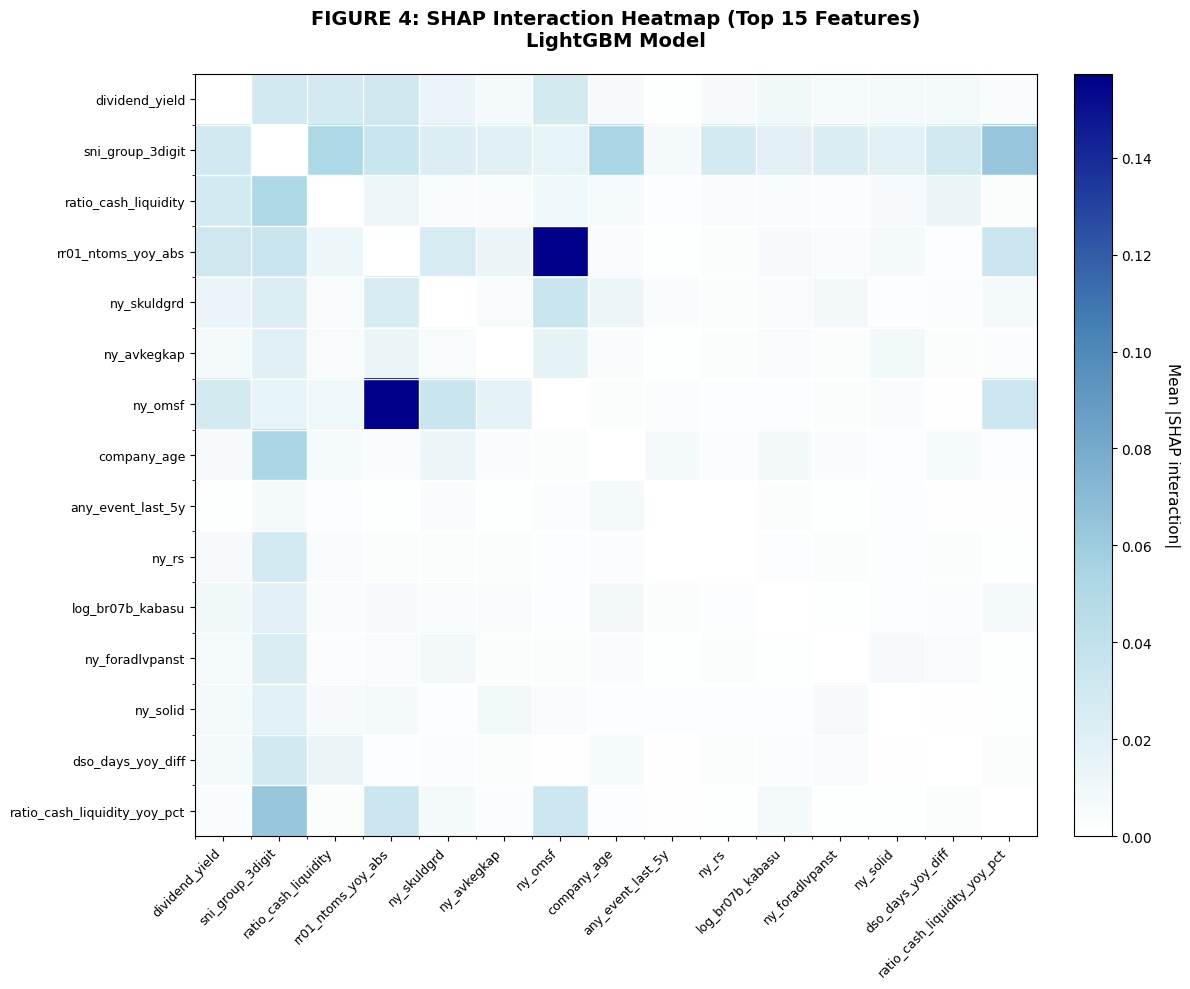


Reading the heatmap:
  • Darker colors = stronger interactions
  • Diagonal (self-interaction) excluded from analysis
  • Matrix is symmetric (interaction between A and B = interaction between B and A)


In [17]:
# Create visualization: Heatmap of interaction matrix for top features
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Get indices of top 15 features
top_15_features = importance_comparison.head(15)['feature'].tolist()
top_15_indices = [X_val.columns.get_loc(f) for f in top_15_features]

# Extract submatrix for top features
interaction_submatrix = interaction_matrix[np.ix_(top_15_indices, top_15_indices)]

# Create heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap: white to blue
cmap = LinearSegmentedColormap.from_list('interaction', ['white', 'lightblue', 'steelblue', 'darkblue'])

im = ax.imshow(interaction_submatrix, cmap=cmap, aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(top_15_features)))
ax.set_yticks(np.arange(len(top_15_features)))
ax.set_xticklabels(top_15_features, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(top_15_features, fontsize=9)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Mean |SHAP interaction|', rotation=270, labelpad=20, fontsize=11)

# Add title
ax.set_title('FIGURE 4: SHAP Interaction Heatmap (Top 15 Features)\nLightGBM Model', 
             fontsize=14, fontweight='bold', pad=20)

# Add grid for better readability
ax.set_xticks(np.arange(len(top_15_features)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(top_15_features)) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

print("\nReading the heatmap:")
print("  • Darker colors = stronger interactions")
print("  • Diagonal (self-interaction) excluded from analysis")
print("  • Matrix is symmetric (interaction between A and B = interaction between B and A)")